In [24]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
import matplotlib.pyplot as plt
import copy


In [2]:
# for reproducibility

torch.manual_seed(1)

In [3]:
# define feedforward neural network

class Net(nn.Module):
    def __init__(self, input_dim, feature_dim, out_dim):
        super(Net, self).__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, feature_dim),
            nn.ReLU(),
            nn.Linear(feature_dim, out_dim),
            nn.ReLU()
        )
    
    def forward(self, inputs):
        return self.classifier(inputs)

In [4]:
# load data

train = MNIST(root='../data/mnist/demo/', train=True, transform=ToTensor(), download=True)
test = MNIST(root='../data/mnist/demo/', train=False, transform=ToTensor(), download=True)

In [5]:
train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

In [6]:
# load checkpoint from SGD

in_dim, feature_dim, out_dim = 784, 256, 10
lr = 1e-4
loss_fn = nn.CrossEntropyLoss()
num_epochs = 20
classifier = Net(in_dim, feature_dim, out_dim)
optimizer = optim.SGD(classifier.parameters(), lr=lr)
classifier

Net(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [7]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for input, label in train_loader:
        optimizer.zero_grad()
        output = classifier(input)
        loss = loss_fn(output, label)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch+1} loss: {running_loss/len(train_loader)}')

Epoch 1 loss: 2.3046294684603272
Epoch 2 loss: 2.2975979547764953
Epoch 3 loss: 2.2907330453522934
Epoch 4 loss: 2.283577099791976
Epoch 5 loss: 2.275064650374943
Epoch 6 loss: 2.264572544646924
Epoch 7 loss: 2.2532858380885012
Epoch 8 loss: 2.241703520705705
Epoch 9 loss: 2.229530222888694
Epoch 10 loss: 2.216832691164159
Epoch 11 loss: 2.203674297597108
Epoch 12 loss: 2.1902154551894424
Epoch 13 loss: 2.17646878894204
Epoch 14 loss: 2.162485155977928
Epoch 15 loss: 2.148180947629119
Epoch 16 loss: 2.133601605638004
Epoch 17 loss: 2.1186788880240432
Epoch 18 loss: 2.103463502835109
Epoch 19 loss: 2.0880314295988347
Epoch 20 loss: 2.072307128387728


In [8]:
model = classifier
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
classifier.1.weight 	 torch.Size([256, 784])
classifier.1.bias 	 torch.Size([256])
classifier.3.weight 	 torch.Size([10, 256])
classifier.3.bias 	 torch.Size([10])


In [9]:
# save state to a file checkpoint

torch.save(model.state_dict(), '../model/mnist.pt')

# How Pesky Are Spurious Local Minima in Deep Networks?

In [10]:
in_dim, feat_dim, out_dim = 784, 256, 10
model = Net(in_dim, feat_dim, out_dim)

In [11]:
model

Net(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [12]:
model.load_state_dict(torch.load('../model/mnist.pt'))

<All keys matched successfully>

In [14]:
# access parameter with state_dict

opt_state_dict = copy.deepcopy(model.state_dict()) # copy dictionary with it's value

In [15]:
opt_state_dict

OrderedDict([('classifier.1.weight',
              tensor([[ 0.0184, -0.0158, -0.0069,  ...,  0.0068, -0.0041,  0.0025],
                      [-0.0274, -0.0224, -0.0309,  ..., -0.0029,  0.0013, -0.0167],
                      [ 0.0282, -0.0095, -0.0340,  ..., -0.0141,  0.0056, -0.0335],
                      ...,
                      [ 0.0192,  0.0144, -0.0119,  ...,  0.0232,  0.0299, -0.0147],
                      [-0.0241,  0.0189,  0.0124,  ..., -0.0007, -0.0108,  0.0064],
                      [-0.0337, -0.0356,  0.0058,  ...,  0.0089, -0.0317,  0.0223]])),
             ('classifier.1.bias',
              tensor([ 0.0087, -0.0260,  0.0320, -0.0097,  0.0243, -0.0049,  0.0263,  0.0194,
                       0.0174,  0.0254, -0.0321, -0.0045, -0.0069,  0.0195, -0.0337,  0.0275,
                      -0.0094,  0.0134, -0.0006, -0.0144, -0.0081,  0.0364,  0.0064,  0.0126,
                      -0.0043,  0.0205,  0.0046, -0.0138, -0.0270, -0.0068,  0.0090, -0.0122,
                  

In [16]:
for params in opt_state_dict:
    print(params, '\t', opt_state_dict[params].size())

classifier.1.weight 	 torch.Size([256, 784])
classifier.1.bias 	 torch.Size([256])
classifier.3.weight 	 torch.Size([10, 256])
classifier.3.bias 	 torch.Size([10])


In [17]:
# Create randomly initialized network

model = Net(in_dim, feat_dim, out_dim)
rand_state_dict = copy.deepcopy(model.state_dict())

In [18]:
# construct linear interpolation using mixing parameter alpha and beta
# new state dict for interpolated parameters

test_model = Net(in_dim, feat_dim, out_dim)
test_state_dict = copy.deepcopy(test_model.state_dict())

alpha = 0.2
beta = 1.0 - alpha
for p in opt_state_dict:
    test_state_dict[p] = alpha * opt_state_dict[p] + beta * rand_state_dict[p]

In [19]:
# average loss over the entire test set using the interpolated parameters

def inference(test_loader, model, loss_fn):
    running_loss = 0.0
    with torch.no_grad():
        for input, label in test_loader:
            output = model(input)
            loss = loss_fn(output, label)
            running_loss += loss
    running_loss /= len(test_loader)
    return running_loss


In [20]:
opt_state_dict['classifier.1.weight'].size()

torch.Size([256, 784])

In [21]:
opt_state_dict['classifier.1.weight'][0][0]

tensor(0.0184)

In [22]:
# vary value of alpha to understand how error surface changes as we traverse the line between randomlly initialized and optimized parameters

results = []
for alpha in torch.arange(-2, 2, 0.05):
    beta = 1.0 - alpha

    # compute interpolated parameters
    for p in opt_state_dict:
        test_state_dict[p] = alpha * opt_state_dict[p] + beta * rand_state_dict[p]
    
    # load interpolated parameters into test model
    model.load_state_dict(test_state_dict)

    # compute loss
    loss = inference(train_loader, model, loss_fn)
    results.append(loss.item())
    print(f'alpha: {alpha:.2f}, loss: {loss:.2f}')
    

alpha: -2.00, loss: 2.40
alpha: -1.95, loss: 2.39
alpha: -1.90, loss: 2.38
alpha: -1.85, loss: 2.38
alpha: -1.80, loss: 2.37
alpha: -1.75, loss: 2.36
alpha: -1.70, loss: 2.35
alpha: -1.65, loss: 2.35
alpha: -1.60, loss: 2.34
alpha: -1.55, loss: 2.34
alpha: -1.50, loss: 2.33
alpha: -1.45, loss: 2.33
alpha: -1.40, loss: 2.33
alpha: -1.35, loss: 2.32
alpha: -1.30, loss: 2.32
alpha: -1.25, loss: 2.32
alpha: -1.20, loss: 2.32
alpha: -1.15, loss: 2.31
alpha: -1.10, loss: 2.31
alpha: -1.05, loss: 2.31
alpha: -1.00, loss: 2.31
alpha: -0.95, loss: 2.31
alpha: -0.90, loss: 2.31
alpha: -0.85, loss: 2.31
alpha: -0.80, loss: 2.31
alpha: -0.75, loss: 2.31
alpha: -0.70, loss: 2.31
alpha: -0.65, loss: 2.31
alpha: -0.60, loss: 2.31
alpha: -0.55, loss: 2.31
alpha: -0.50, loss: 2.31
alpha: -0.45, loss: 2.31
alpha: -0.40, loss: 2.31
alpha: -0.35, loss: 2.31
alpha: -0.30, loss: 2.31
alpha: -0.25, loss: 2.31
alpha: -0.20, loss: 2.31
alpha: -0.15, loss: 2.31
alpha: -0.10, loss: 2.31
alpha: -0.05, loss: 2.31


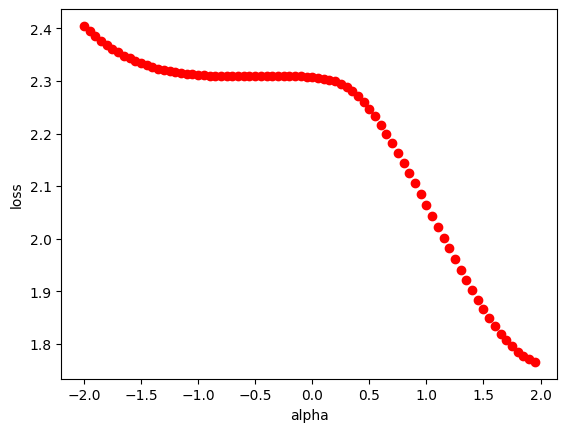

In [25]:
plt.plot(np.arange(-2, 2, 0.05), results, 'ro')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()